**Introduction**

While classical computers use only pseudo-random routines, quantum computers can generate true random variates. For example, the measurement of a quantum superposition is intrinsically random, as suggested by Born's rule. Consequently, some of the best random-number generators are based on such quantum-mechanical effects. Further, with a logarithmic amount of random bits, quantum computers can produce linearly many more bits, which is known as randomness expansion protocols.

In practical applications, one wishes to use random variates of well-known distributions, rather than random bits. In this notebook, we illustrate ways of generating random variates of several popular distributions on IBM Q.

Random Bits and the Bernoulli distribution

It is clear that there are many options for generating random bits (i.e., Bernoulli-distributed scalars, taking values either 0 or 1). Starting from a simple circuit such as a Hadamard gate followed by measurement, one can progress to vectors of Bernoulli-distributed elements. By addition of such random variates, we could get binomial distributions. By multiplication we could get geometric distributions, although perhaps leading to a circuit depth that may be impratical at the moment, though.

(Source: https://github.com/Qiskit/qiskit-tutorials/blob/bea399999cda8712caa207a7172854467f9011ad/qiskit/aqua/generating_random_variates.ipynb)

Let us start by importing the basic modules and creating a quantum circuit for generating random bits:

In [13]:
import sys, math, time, warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from qiskit import BasicAer, QuantumCircuit, QuantumRegister, ClassicalRegister, execute

import matplotlib.pyplot as plt, numpy as np
%matplotlib inline

global_strBackend = BasicAer.get_backend( "qasm_simulator" )

In [14]:
global_intNumQubits = 5

def CreateCircuit( intNumTargetQubits: int ) -> QuantumCircuit:
    """
    Creates and returns quantum circuit for random variate generation.
    :param intNumTargetQubits: number of qubits to be used.
    :return: quantum curcuit.
    """
    
    assert isinstance( intNumTargetQubits, int ) and intNumTargetQubits > 0
    q = QuantumRegister( intNumTargetQubits )
    c = ClassicalRegister( intNumTargetQubits )
    circuit = QuantumCircuit( q, c )
    circuit.h( q )
    circuit.barrier()
    circuit.measure( q, c )
    return circuit

circuit = CreateCircuit( global_intNumQubits )

In [15]:
def UniformRandFloat64( circuit: QuantumCircuit, intNumTargetQubits: int,
                         intSize: int, intVmin: float, intVmax: float) -> np.ndarray:
    """
    Generates a vector of random float64 values in the range [intVmin, intVmax].
    :param circuit: quantum circuit for random variate generation.
    :param intNumTargetQubits: number of qubits to be used.
    :param intSize: length of the vector.
    :param intVmin: lower bound.
    :param intVmax: upper bound.
    :return: vector of random values.
    """
    
    assert sys.maxsize == np.iinfo( np.int64 ).max    # intSizeof(int) == 64 bits
    assert isinstance( intSize, int ) and intSize > 0
    assert isinstance( intVmin, float ) and isinstance( intVmax, float ) and intVmin <= intVmax
    
    intNbits = 7 * 8
    intBitStrLen = (intNbits * intSize + intNumTargetQubits - 1) // intNumTargetQubits
    
    job = execute( circuit, global_strBackend, shots = intBitStrLen, memory = True)
    intBitStr = '' . join( job.result().get_memory() )
    
    fltScale = float( intVmax - intVmin ) / float( 2**intNbits - 1 )
    
    return np.array( [ intVmin + fltScale * float( int( intBitStr[ i:i + intNbits ], 2 ) )
                     for i in range( 0, intNbits * intSize, intNbits ) ], dtype = np.float64 )

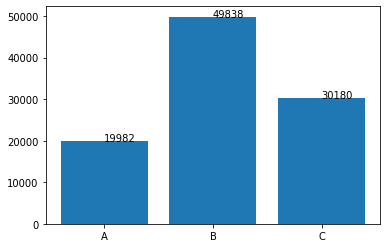

Min: 0.0000, Max: 1.0000, Size: 100000
Count of A: 19982
Count of B: 49838
Count of C: 30180
*** took 12.34 secs.


In [16]:
fltStartTime = time.time()
intSize = 100000
intVmin = 0.0
intVmax = 1.0
arr_fltSample = UniformRandFloat64( circuit, global_intNumQubits, intSize, intVmin, intVmax )

intCountA = 0
intCountB = 0
intCountC = 0

for i in range( 0, intSize ):
    if arr_fltSample[ i ] <= 0.2:
        intCountA += 1
    elif arr_fltSample[ i ] > 0.2 and arr_fltSample[ i ] <= 0.7:
         intCountB += 1
    else:
         intCountC += 1

strXaxis = [ "A", "B", "C" ]
intYaxis = [ intCountA, intCountB, intCountC ]
plt.bar( strXaxis, intYaxis )
for i, j in zip( strXaxis, intYaxis ):
    plt.text( i, j, str( j ) )
plt.show()

print( "Min: {:.4f}, Max: {:.4f}, Size: {:d}".format(intVmin, intVmax, intSize ) )
print( "Count of A:", intCountA )
print( "Count of B:", intCountB )
print( "Count of C:", intCountC )

print("*** took", round( time.time() - fltStartTime, 2 ), "secs.")